# Pbar Globe 2nd Try

I think I need a clean slate where I can start at the very beginning and test each step along the way. I'm assuming most/all of this code will be pulled from pbar_globe, but there's a lot going on there, and I tried to jump to the finish line and it didn't go well.

# Housekeeping

## Imports and plotting params

In [71]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter
import scipy.interpolate as interpolate
from flox.xarray import xarray_reduce
from xgcm.autogenerate import generate_grid_ds
from xgcm import Grid
from tqdm import tqdm
from scipy.ndimage import uniform_filter1d

In [2]:
import os
os.chdir('/home.ufs/amf2288/argo-intern/funcs')
import filt_funcs as ff
import density_funcs as df

In [3]:
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize']  = 18
plt.rcParams['axes.labelsize']  = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

## Load pre-made datasets

In [109]:
ds_p = xr.open_dataset('/swot/SUM05/amf2288/res_2.5/ds_p.nc').rename({'PRES_INTERPOLATED':'pressure','N_PROF':'prof','LATITUDE':'lat','LONGITUDE':'lon'})                #individual profiles where sampling rate <=2.5m, pressure grid
ds_r = xr.open_dataset('/swot/SUM05/amf2288/res_2.5/ds_r.nc').rename({'LATITUDE':'lat','LONGITUDE':'lon'})             #individual profiles where sampling rate <=2.5m, density grid

ds_p_grid3 = xr.open_dataset('/swot/SUM05/amf2288/res_2.5/ds_p_grid3.nc')     #3x3 gridded dataset where sampling rate <=2.5m, pressure grid
#ds_r_grid3 = xr.open_dataset('/swot/SUM05/amf2288/res_2.5/ds_rho_grid3.nc') #3x3 gridded dataset where sampling rate <=2.5m, density grid

RG_p = xr.open_dataset('/swot/SUM05/amf2288/RG_clim/RG_p.nc')
RG_r = xr.open_dataset('/swot/SUM05/amf2288/RG_clim/RG_r.nc')

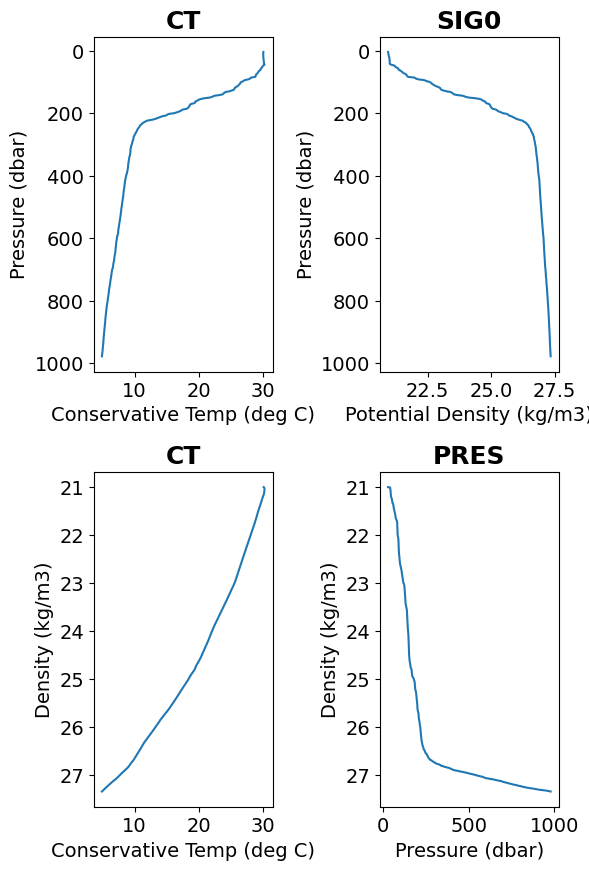

In [111]:
num = 832906
prof_p = ds_p.isel(prof=num)
prof_r = ds_r.isel(prof=num)

plt.figure(figsize=(6,10))
plt.subplot(221)
prof_p.CT.plot(y='pressure')
plt.gca().invert_yaxis()
plt.ylabel('Pressure (dbar)')
plt.xlabel('Conservative Temp (deg C)')
plt.title('CT')

plt.subplot(222)
prof_p.SIG0.plot(y='pressure')
plt.gca().invert_yaxis()
plt.ylabel('Pressure (dbar)')
plt.xlabel('Potential Density (kg/m3)')
plt.title('SIG0')

plt.subplot(223)
prof_r.CT.plot(y='density')
plt.gca().invert_yaxis()
plt.ylabel('Density (kg/m3)')
plt.xlabel('Conservative Temp (deg C)')
plt.title('CT')

plt.subplot(224)
prof_r.PRES.plot(y='density')
plt.gca().invert_yaxis()
plt.ylabel('Density (kg/m3)')
plt.xlabel('Pressure (dbar)')
plt.title('PRES')

plt.subplots_adjust(wspace=0.6, hspace=0.3)

# Create ds_pmean

## Construct $p-\rho$ relationship

In [112]:
def match_mean_profiles(ds_rho, pres_rho_gridded, lon_bins, lat_bins):
    # Bin indices
    lat_idx = np.digitize(ds_rho.lat.values, lat_bins) - 1
    lon_idx = np.digitize(ds_rho.lon.values, lon_bins) - 1

    # Validate indices
    valid = (
        (lat_idx >= 0) & (lat_idx < pres_rho_gridded.sizes['lat']) &
        (lon_idx >= 0) & (lon_idx < pres_rho_gridded.sizes['lon'])
    )

    # Transpose to match original indexing: [density, lon, lat]
    pres_grid = pres_rho_gridded.transpose('density', 'lon', 'lat').values

    # Initialize output
    matched_profiles = np.full(
        (ds_rho.sizes['prof'], ds_rho.sizes['density']),
        np.nan,
        dtype=np.float32
    )

    # Loop with progress bar
    for i in tqdm(range(ds_rho.sizes['prof']), desc="Matching profiles", unit="profile"):
        if valid[i]:
            try:
                matched_profiles[i, :] = pres_grid[:, lon_idx[i], lat_idx[i]]
            except IndexError:
                continue

    # Return as DataArray
    return xr.DataArray(
        matched_profiles,
        dims=('prof', 'density'),
        coords={'prof': ds_rho.prof, 'density': ds_rho.density}
    )

In [113]:
lon_bins = np.arange(-180,181,3)
lat_bins = np.arange(-90,91,3)

In [114]:
ds_r['pres_mean'] = match_mean_profiles(ds_r, RG_r.PRES, lon_bins, lat_bins)

Matching profiles: 100%|██████████| 1488063/1488063 [00:16<00:00, 92195.41profile/s]


In [115]:
ds_r

<xarray.Dataset> Size: 191GB
Dimensions:    (density: 3200, prof: 1488063)
Coordinates:
  * density    (density) float64 26kB 21.0 21.0 21.01 21.01 ... 28.99 29.0 29.0
  * prof       (prof) int64 12MB 2428701 1114461 2155018 ... 1502504 411205
    lat        (prof) float64 12MB -78.16 -78.15 -78.15 ... 89.75 89.77 89.78
    lon        (prof) float64 12MB -174.6 -161.6 -175.1 ... -14.96 -99.35 139.1
    TIME       (prof) datetime64[ns] 12MB ...
Data variables:
    CT         (prof, density) float64 38GB ...
    SA         (prof, density) float64 38GB ...
    SIG0       (prof, density) float64 38GB ...
    SPICE      (prof, density) float64 38GB ...
    PRES       (prof, density) float32 19GB ...
    pres_mean  (prof, density) float32 19GB -9.223e+18 -9.223e+18 ... -9.223e+18

/home.ufs/amf2288/miniforge3/envs/Argo_old_xgcm/lib/python3.12/site-packages/xarray/plot/utils.py:245: RuntimeWarning: overflow encountered in scalar absolute
  vlim = max(abs(vmin - center), abs(vmax - center))


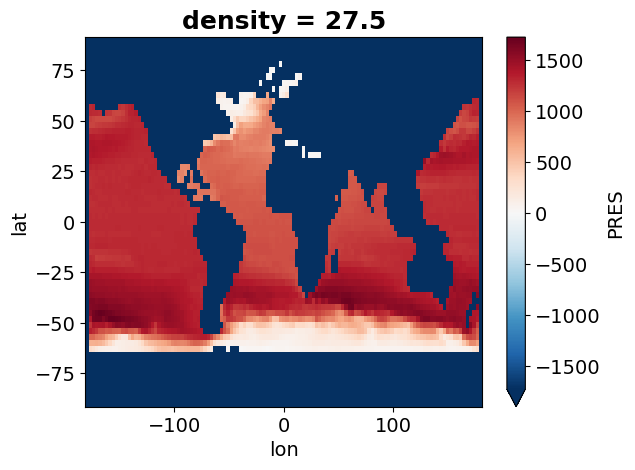

In [116]:
RG_r.sel(density=27.5, method='nearest').PRES.plot()

PROF lat: 5.635, lon: 166.094
MEAN lat: 6, lon: 165


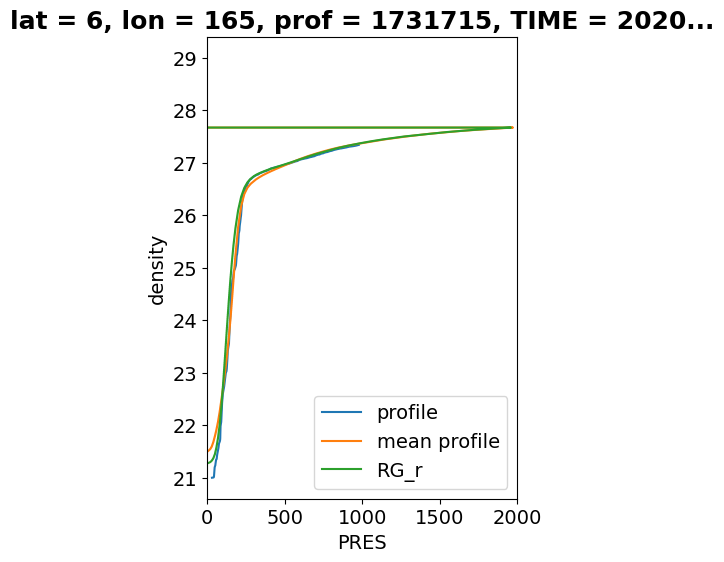

In [117]:
num = 832906
prof = ds_r.isel(prof=num)
mean = RG_r.PRES.sel(lat=prof.lat, lon=prof.lon, method='nearest')
print(f'PROF lat: {prof.lat.values}, lon: {prof.lon.values}')
print(f'MEAN lat: {mean.lat.values}, lon: {mean.lon.values}')

plt.figure(figsize=(4,6))
prof.PRES.plot(y='density', label='profile')
prof.pres_mean.plot(y='density',  label='mean profile')
mean.plot(y='density', label='RG_r')
plt.xlim(0,2000)
plt.legend();

## Interpolate ds_rho to ds_pmean

In [120]:
def make_progress_wrapper(base_func, total, desc):
    bar = tqdm(total=total, desc=desc, unit="profile")

    def wrapped(var_profile, pres_mean, pmean_grid, roll=50):
        result = base_func(var_profile, pres_mean, pmean_grid, roll=roll)
        bar.update(1)
        return result

    return wrapped

In [118]:
def interp_to_pmean(var_profile, pres_mean, pmean_grid, roll=50):
    try:
        # Apply a centered moving average using a uniform filter
        pmean_smooth = uniform_filter1d(pres_mean, size=roll, mode='nearest', origin=0)

        valid = ~np.isnan(var_profile) & ~np.isnan(pmean_smooth)
        var_nonan = var_profile[valid]
        pmean_nonan = pmean_smooth[valid]

        if len(pmean_nonan) < 3:
            return np.full_like(pmean_grid, np.nan)

        fvar = interpolate.PchipInterpolator(pmean_nonan, var_nonan, extrapolate=False)
        return fvar(pmean_grid)

    except ValueError:
        return np.full_like(pmean_grid, np.nan)

In [122]:
def get_ds_pmean(ds_r, pmean_grid, variables, dim1='prof', dim_dens='density', dim_pmean='pmean', roll=50):
    xrs = []
    pmean_size = pmean_grid.size
    n_profiles = ds_r.sizes[dim1]

    for var in variables:
        print(f"Starting interpolation for {var}")
        wrapped_interp = make_progress_wrapper(interp_to_pmean, total=n_profiles, desc=f"{var}")

        var_interp = xr.apply_ufunc(
            wrapped_interp, ds_r[var], ds_r['pres_mean'],
            input_core_dims=[[dim_dens], [dim_dens]],
            output_core_dims=[[dim_pmean]],
            dask_gufunc_kwargs={'output_sizes': {dim_pmean: pmean_size}},
            vectorize=True,
            dask='parallelized',
            kwargs={'pmean_grid': pmean_grid, 'roll': roll},
            output_dtypes=[ds_r[var].dtype]
        )

        var_interp = xr.DataArray(
            data=var_interp.data,
            dims=[dim1, dim_pmean],
            coords={dim_pmean: pmean_grid, dim1: ds_r[dim1]},
            name=var
        )
        xrs.append(var_interp)
        print(f"Completed {var}")

    ds_pmean = xr.merge(xrs)
    ds_pmean = ds_pmean.assign_coords(lat=('prof', ds_r.lat.data))
    ds_pmean = ds_pmean.assign_coords(lon=('prof', ds_r.lon.data))

    return ds_pmean.rename({dim_pmean: 'pmean'})

ERROR! Session/line number was not unique in database. History logging moved to new session 1193


CT:  15%|█▍        | 222362/1488063 [01:15<03:56, 5361.91profile/s]

In [123]:
CT_pmean_50 = get_ds_pmean(ds_r, np.linspace(0,2000,1001), ['CT'], roll=50)

Starting interpolation for CT


CT:   0%|          | 385/1488063 [00:00<06:26, 3847.55profile/s]

ERROR! Session/line number was not unique in database. History logging moved to new session 1194


CT: 100%|██████████| 1488063/1488063 [04:50<00:00, 5115.61profile/s]

Completed CT


In [124]:
CT_pmean_25 = get_ds_pmean(ds_r, np.linspace(0,2000,1001), ['CT'], roll=25)

Starting interpolation for CT


CT: 100%|██████████| 1488063/1488063 [04:48<00:00, 5154.87profile/s]

Completed CT


In [125]:
CT_pmean_10 = get_ds_pmean(ds_r, np.linspace(0,2000,1001), ['CT'], roll=10)

Starting interpolation for CT


CT: 100%|██████████| 1488063/1488063 [04:34<00:00, 5428.14profile/s]

Completed CT


In [126]:
CT_pmean_100 = get_ds_pmean(ds_r, np.linspace(0,2000,1001), ['CT'], roll=100)

Starting interpolation for CT


CT: 100%|██████████| 1488063/1488063 [04:54<00:00, 5053.45profile/s]

Completed CT


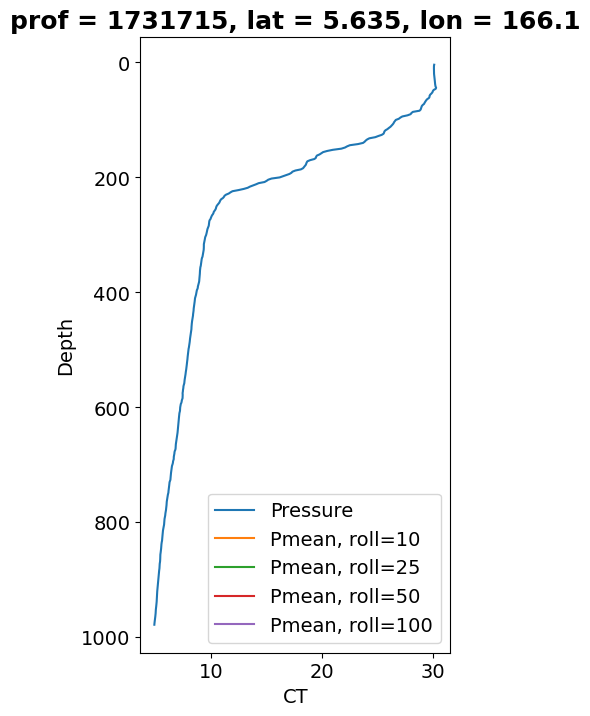

In [127]:
plt.figure(figsize=(4,8))

num = 832906
ds_p.CT.isel(prof=num).plot(y='pressure', label='Pressure')
CT_pmean_10.CT.isel(prof=num).plot(y='pmean', label='Pmean, roll=10')
CT_pmean_25.CT.isel(prof=num).plot(y='pmean', label='Pmean, roll=25')
CT_pmean_50.CT.isel(prof=num).plot(y='pmean', label='Pmean, roll=50')
CT_pmean_100.CT.isel(prof=num).plot(y='pmean', label='Pmean, roll=100')
plt.gca().invert_yaxis()
plt.ylabel('Depth')
plt.legend()

In [128]:
def get_ds_gridded(ds, lon_bins, lat_bins):
    # Step 1: Reduce using flox
    ds_binned = xarray_reduce(
        ds,
        'lon',
        'lat',
        func='mean',
        expected_groups=(
            pd.IntervalIndex.from_breaks(lon_bins),
            pd.IntervalIndex.from_breaks(lat_bins)
        ),
        fill_value=np.nan,
        skipna=True
    )

    # Step 2: Rename dimensions and variables
    ds_binned = ds_binned.rename_dims({
        'lon_bins': 'lon',
        'lat_bins': 'lat',}).rename_vars({
        #'rho_grid': 'density'
        'lon_bins': 'lon',
        'lat_bins': 'lat',
        #'rho_grid': 'density'
    })

    # Step 3: Replace Interval coordinates with midpoints
    def interval_midpoints(intervals):
        return np.array([interval.mid for interval in intervals])

    ds_binned = ds_binned.assign_coords({
        'lon': ('lon', interval_midpoints(ds_binned['lon'].values)),
        'lat': ('lat', interval_midpoints(ds_binned['lat'].values))
    })

    # Step 4: Generate grid and xgcm object
    ds_gridded = generate_grid_ds(ds_binned, {'X': 'lon', 'Y': 'lat'})
    grid = Grid(ds_gridded, coords={
        'X': {'center': 'lon', 'left': 'lon_left'},
        'Y': {'center': 'lat', 'left': 'lat_left'},
        'Z': {'center': 'pmean'}
    }, periodic=['X'])

    return ds_gridded, grid

In [129]:
CT_pmean_grid_10, grid = get_ds_gridded(CT_pmean_10, lon_bins, lat_bins)
CT_pmean_grid_25, grid = get_ds_gridded(CT_pmean_25, lon_bins, lat_bins)
CT_pmean_grid_50, grid = get_ds_gridded(CT_pmean_50, lon_bins, lat_bins)
CT_pmean_grid_100, grid = get_ds_gridded(CT_pmean_100, lon_bins, lat_bins)

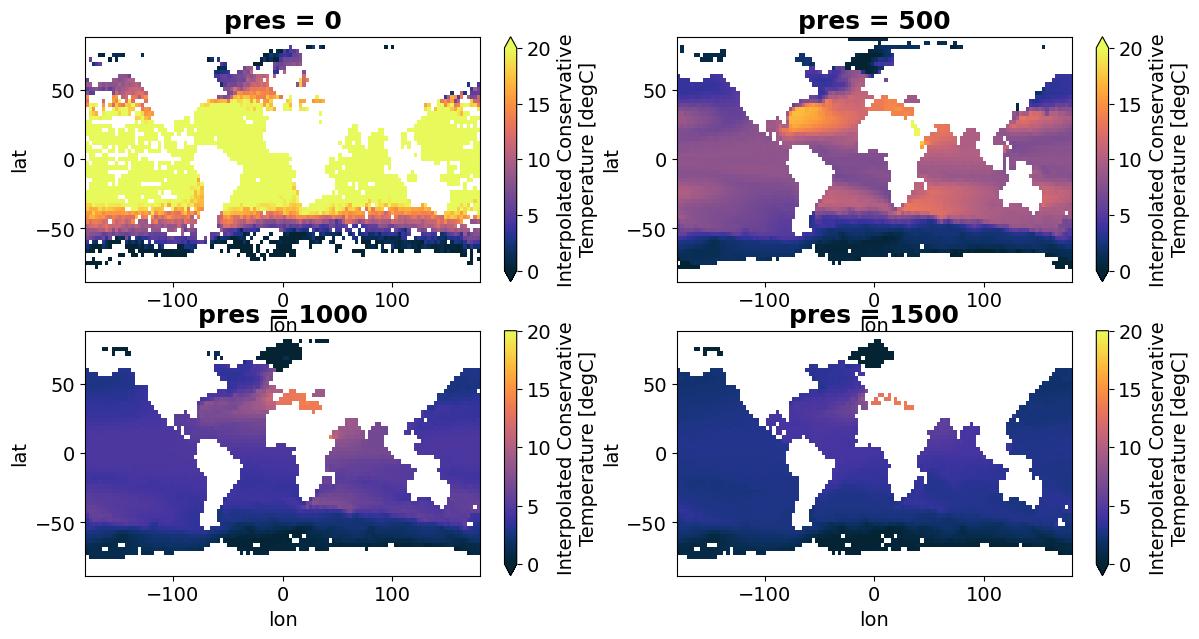

In [131]:
plt.figure(figsize=(14,7))

plt.subplot(221)
ds_p_grid3.CT.sel(pres=0, method='nearest').plot(x='lon',y='lat', cmap=cmo.thermal, vmin=0, vmax=20)

plt.subplot(222)
ds_p_grid3.CT.sel(pres=500, method='nearest').plot(x='lon',y='lat', cmap=cmo.thermal, vmin=0, vmax=20)

plt.subplot(223)
ds_p_grid3.CT.sel(pres=1000, method='nearest').plot(x='lon',y='lat', cmap=cmo.thermal, vmin=0, vmax=20)

plt.subplot(224)
ds_p_grid3.CT.sel(pres=1500, method='nearest').plot(x='lon',y='lat', cmap=cmo.thermal, vmin=0, vmax=20)

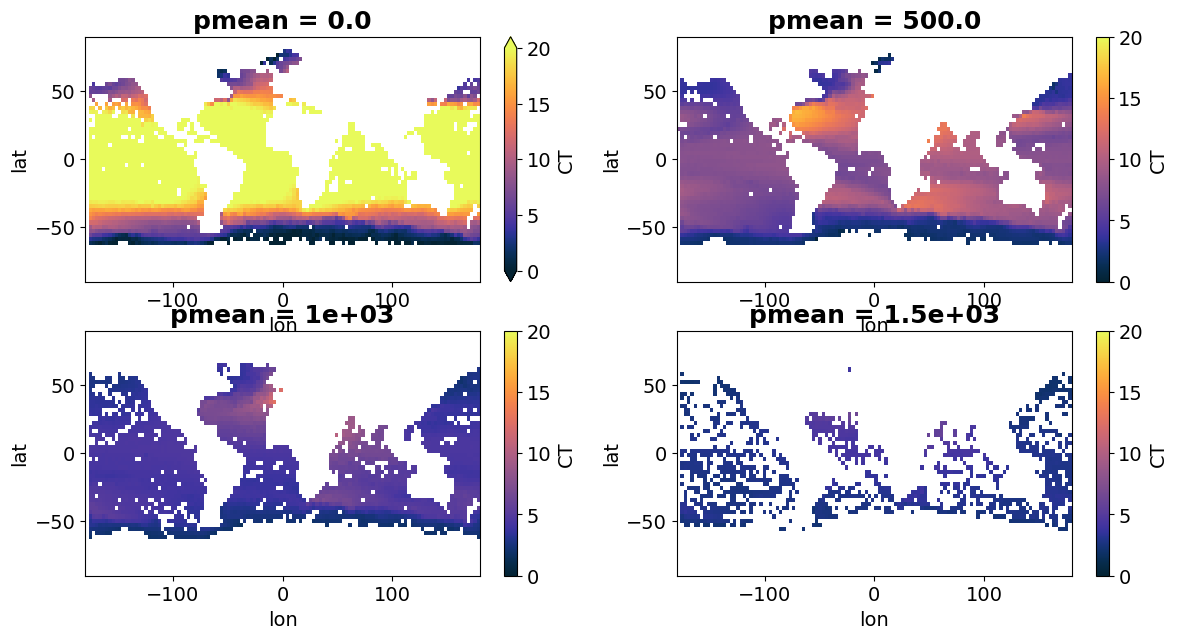

In [132]:
plt.figure(figsize=(14,7))

plt.subplot(221)
CT_pmean_grid_50.CT.sel(pmean=0, method='nearest').plot(x='lon',y='lat', cmap=cmo.thermal, vmin=0, vmax=20)

plt.subplot(222)
CT_pmean_grid_50.CT.sel(pmean=500, method='nearest').plot(x='lon',y='lat', cmap=cmo.thermal, vmin=0, vmax=20)

plt.subplot(223)
CT_pmean_grid_50.CT.sel(pmean=1000, method='nearest').plot(x='lon',y='lat', cmap=cmo.thermal, vmin=0, vmax=20)

plt.subplot(224)
CT_pmean_grid_50.CT.sel(pmean=1500, method='nearest').plot(x='lon',y='lat', cmap=cmo.thermal, vmin=0, vmax=20)

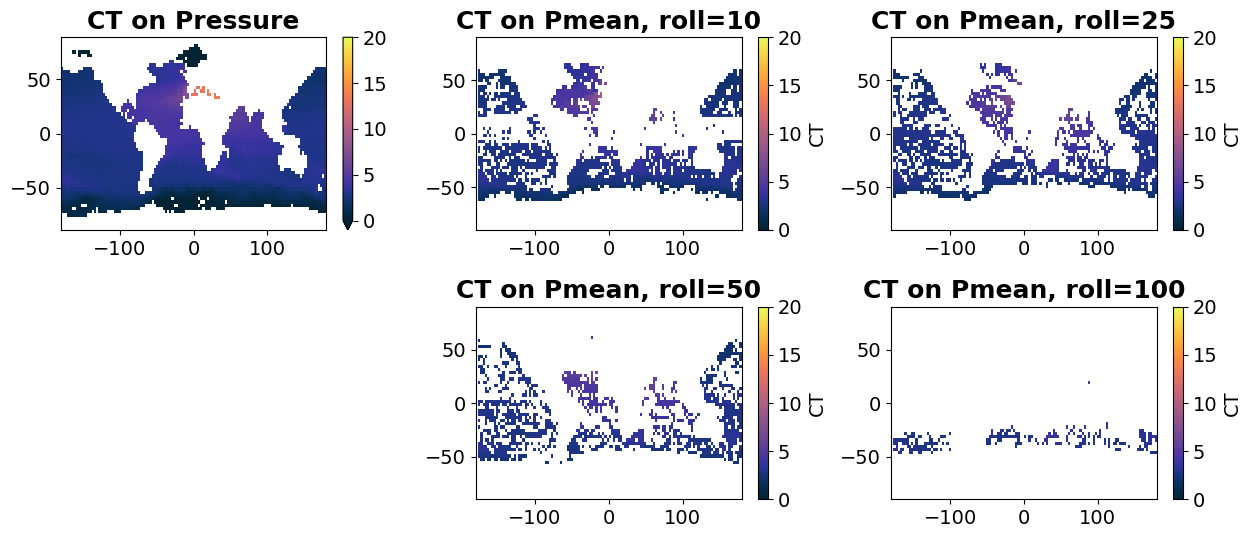

In [154]:
plt.figure(figsize=(15,6))
depth = 1500

plt.subplot(231)
ds_p_grid3.CT.sel(pres=depth, method='nearest').plot(x='lon',y='lat', cmap=cmo.thermal, vmin=0, vmax=20, cbar_kwargs={'label': ''})
plt.xlabel('')
plt.ylabel('')
plt.title('CT on Pressure')

plt.subplot(232)
CT_pmean_grid_10.CT.sel(pmean=depth, method='nearest').plot(x='lon',y='lat', cmap=cmo.thermal, vmin=0, vmax=20)
plt.xlabel('')
plt.ylabel('')
plt.title('CT on Pmean, roll=10')

plt.subplot(233)
CT_pmean_grid_25.CT.sel(pmean=depth, method='nearest').plot(x='lon',y='lat', cmap=cmo.thermal, vmin=0, vmax=20)
plt.xlabel('')
plt.ylabel('')
plt.title('CT on Pmean, roll=25')

plt.subplot(235)
CT_pmean_grid_50.CT.sel(pmean=depth, method='nearest').plot(x='lon',y='lat', cmap=cmo.thermal, vmin=0, vmax=20)
plt.xlabel('')
plt.ylabel('')
plt.title('CT on Pmean, roll=50')

plt.subplot(236)
CT_pmean_grid_100.CT.sel(pmean=depth, method='nearest').plot(x='lon',y='lat', cmap=cmo.thermal, vmin=0, vmax=20)
plt.xlabel('')
plt.ylabel('')
plt.title('CT on Pmean, roll=100')

plt.subplots_adjust(wspace=0.25, hspace=0.4)